In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.backends.cudnn
torch.backends.cudnn.benchmark = True

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [11]:
num_epochs_CNN = 20
batch_size_CNN = 128
learning_rate_CNN = 0.001
reg_CNN = 1e-4

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 Dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split train and val
num_train = 49000
num_val = 1000
train_set, val_set = torch.utils.data.random_split(train_val_dataset, [num_train, len(train_val_dataset)-num_train])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_CNN, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size_CNN, shuffle=False, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_CNN, shuffle=False, num_workers=4, pin_memory=True)


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64 * 8 * 8, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

model_CNN = CNN().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=learning_rate_CNN, weight_decay=reg_CNN)


In [8]:
from ray import tune
from ray.train import Checkpoint
from ray.train.torch import TorchTrainer
from ray.train import RunConfig, ScalingConfig
from ray.train import CheckpointConfig
from ray.air import session
import torch.nn.functional as F

def train_fc_model(config):
    model = TwoLayerNet(3 * 32 * 32, config["hidden_dim"], 10).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"])
    criterion = nn.CrossEntropyLoss()

    def l2_regularization(model):
        l2 = 0
        for name, param in model.named_parameters():
            if 'weight' in name:
                l2 += torch.norm(param, 2).to(device)**2
        return l2

    for epoch in range(5):  # Keep small for tuning
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss += config["reg"] * l2_regularization(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    session.report({"val_accuracy": acc})

In [9]:
def train_cnn_model(config):
    model = CNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["reg"])
    criterion = nn.CrossEntropyLoss()

    for epoch in range(5):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    session.report({"val_accuracy": acc})


In [10]:
from ray.tune import Tuner, TuneConfig
from ray.tune.schedulers import ASHAScheduler

fc_search_space = {
    "lr": tune.grid_search([0.01, 0.05, 0.1]),
    "hidden_dim": tune.choice([128, 256, 512]),
    "reg": tune.grid_search([1e-4, 1e-3])
}

tuner_fc = Tuner(
    train_fc_model,
    param_space=fc_search_space,
    tune_config=TuneConfig(
        metric="val_accuracy",
        mode="max",
        scheduler=ASHAScheduler(),
        num_samples=1
    )
)

results_fc = tuner_fc.fit()
best_fc = results_fc.get_best_result(metric="val_accuracy", mode="max")
print("Best FC config:", best_fc.config)
print("Best FC accuracy:", best_fc.metrics["val_accuracy"])

ValueError: Tracked actor is not managed by this event manager: <TrackedActor 121209351586568805283187582628128347300>

(raylet) [2025-08-07 13:31:54,907 E 48583 48583] (raylet) node_manager.cc:3041: 8 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 39fac52d59bedac426174cf7f26521e04524885afbbaf1d2a8c75657, IP: 172.27.229.196) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.27.229.196`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) 
(raylet) [2025-08-07 13:32:54,908 E 48583 48583] (raylet) node_manager.cc:3041: 9 Workers (tasks / acto

In [9]:
train_loss_list_CNN = []
val_loss_list_CNN = []
train_acc_list_CNN = []
val_acc_list_CNN = []

for epoch in range(num_epochs_CNN):
    model_CNN.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model_CNN(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss_list_CNN.append(total_train_loss / len(train_loader))
    train_acc_list_CNN.append(100 * correct_train / total_train)

    # Validation
    model_CNN.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model_CNN(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss_list_CNN.append(total_val_loss / len(val_loader))
    val_acc_list_CNN.append(100 * correct_val / total_val)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss_list_CNN[-1]:.4f}, Train Acc: {train_acc_list_CNN[-1]:.2f}%, "
          f"Val Loss: {val_loss_list_CNN[-1]:.4f}, Val Acc: {val_acc_list_CNN[-1]:.2f}%")

Epoch [1/20], Train Loss: 1.6477, Train Acc: 41.37%, Val Loss: 1.3199, Val Acc: 53.40%
Epoch [2/20], Train Loss: 1.3563, Train Acc: 51.53%, Val Loss: 1.1927, Val Acc: 58.30%
Epoch [3/20], Train Loss: 1.2566, Train Acc: 55.44%, Val Loss: 1.1286, Val Acc: 61.80%
Epoch [4/20], Train Loss: 1.1850, Train Acc: 58.16%, Val Loss: 1.0872, Val Acc: 61.20%
Epoch [5/20], Train Loss: 1.1422, Train Acc: 59.86%, Val Loss: 1.0729, Val Acc: 61.80%
Epoch [6/20], Train Loss: 1.1021, Train Acc: 61.32%, Val Loss: 1.0767, Val Acc: 60.60%
Epoch [7/20], Train Loss: 1.0710, Train Acc: 62.18%, Val Loss: 1.0496, Val Acc: 61.70%
Epoch [8/20], Train Loss: 1.0491, Train Acc: 63.46%, Val Loss: 0.9791, Val Acc: 64.90%
Epoch [9/20], Train Loss: 1.0288, Train Acc: 64.01%, Val Loss: 0.9415, Val Acc: 67.20%
Epoch [10/20], Train Loss: 1.0003, Train Acc: 65.08%, Val Loss: 0.9426, Val Acc: 67.90%
Epoch [11/20], Train Loss: 0.9900, Train Acc: 65.62%, Val Loss: 0.9701, Val Acc: 67.30%
Epoch [12/20], Train Loss: 0.9783, Train 

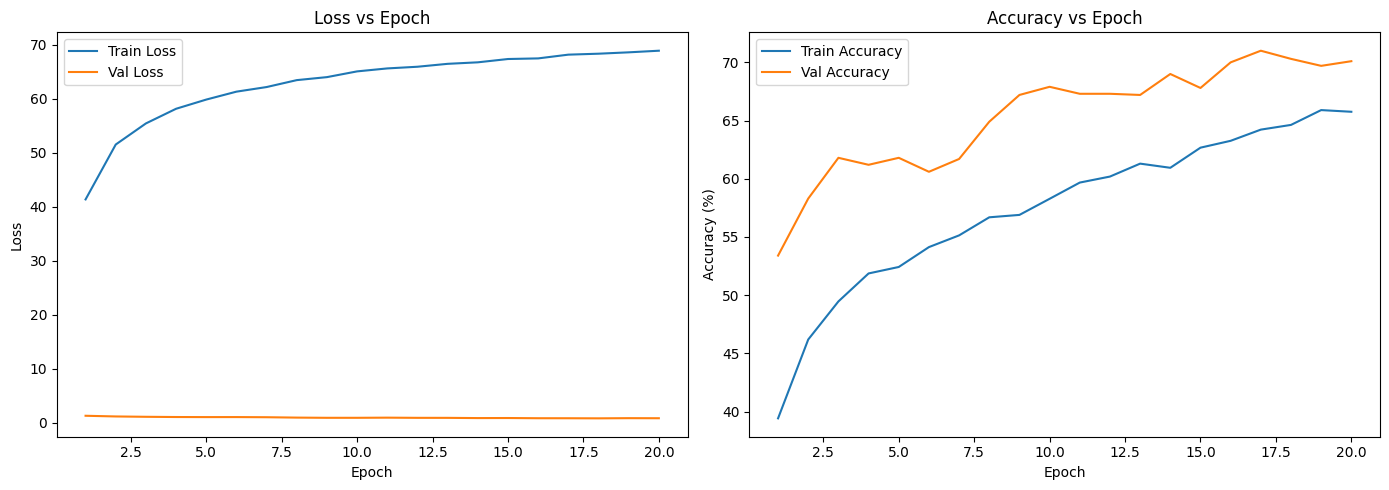

In [10]:
num_epochs_CNN = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(num_epochs_CNN, train_acc_list_CNN, label='Train Loss')
plt.plot(num_epochs_CNN, val_loss_list_CNN, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(num_epochs_CNN, train_acc_list, label='Train Accuracy')
plt.plot(num_epochs_CNN, val_acc_list_CNN, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
model_CNN.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_CNN(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 73.53%


In [12]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 45.39%
